<a href="https://colab.research.google.com/github/pachterlab/BLCSBGLKP_2020/blob/master/notebooks/make_adata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!date

Mon Jun 22 22:16:21 UTC 2020


# Preprocessing FASTQ files into a sample by gene matrix

### Download files and software

In [64]:
!git clone https://github.com/pachterlab/BLCSBGLKP_2020.git
!mkdir temporary

fatal: destination path 'BLCSBGLKP_2020' already exists and is not an empty directory.
mkdir: cannot create directory ‘temporary’: File exists


In [65]:
!chmod +x BLCSBGLKP_2020/data/kb/parseSS.py
!BLCSBGLKP_2020/data/kb/parseSS.py < BLCSBGLKP_2020/data/kb/SampleSheet.csv > temporary/metadata.txt
!cat temporary/metadata.txt | awk '{print $1}' > temporary/whitelist.txt

In [66]:
!head -16 BLCSBGLKP_2020/data/kb/SampleSheet.csv

[Header]
IEMFileVersion,5
Investigator Name,octantbio
Experiment Name,sars_run04
Date,200402
Workflow,GenerateFASTQ
Application,FASTQ Only
Instrument Type,NextSeq
Chemistry,Amplicon
[Reads]
75
[Settings]

[Data]
Plate_ID,index2,Twist_RNA_copies,ATCC_RNA_copies,ATCC_virus_copies,spike_copies,lysate,nCoV_amplicon,nCoV_primer_nM,RPP30_primer_nM,RPP30_inner_primer_nM,bc_set,RT_temp,PCR_cycles,Sample_Well,index,Sample_ID
Plate1,CAGATCTT,0.0,0.0,0.0,100,NP,N1,400,50,100,N1_S2_RPP30,64,40,A01,GAAGACTC,Plate1-A01


In [67]:
!head -1 temporary/metadata.txt
!head -1 temporary/whitelist.txt

GAAGACTCCAGATCTT	GAAGACTC	CAGATCTT	Plate1	A01	N1	NP	0.0	0.0	0.0
GAAGACTCCAGATCTT


### Install kallisto and bustools from GitHub

In [68]:
# We need cmake to install kallisto and bustools from source
!apt update
!apt install -y cmake
!apt-get install autoconf

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Building dependency tree       
Reading state information... Done
53 packages can be upgraded. Run 'apt

In [69]:
!git clone https://github.com/pachterlab/kallisto.git
!mv kallisto/ temporary/
!cd temporary/kallisto && git checkout covid && mkdir build && cd build && cmake .. && make
!chmod +x temporary/kallisto/build/src/kallisto
!mv temporary/kallisto/build/src/kallisto /usr/local/bin/

Cloning into 'kallisto'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 3836 (delta 42), reused 40 (delta 23), pack-reused 3776
Receiving objects: 100% (3836/3836), 4.06 MiB | 9.20 MiB/s, done.
Resolving deltas: 100% (2494/2494), done.
mv: cannot move 'kallisto/' to 'temporary/kallisto': Directory not empty
Already on 'covid'
Your branch is up to date with 'origin/covid'.
mkdir: cannot create directory ‘build’: File exists
chmod: cannot access 'temporary/kallisto/build/src/kallisto': No such file or directory
mv: cannot stat 'temporary/kallisto/build/src/kallisto': No such file or directory


In [70]:
!git clone https://github.com/BUStools/bustools.git
!mv bustools/ temporary/
!cd temporary/bustools && git checkout covid && mkdir build && cd build && cmake .. && make
!chmod +x temporary/bustools/build/src/bustools
!mv temporary/bustools/build/src/bustools /usr/local/bin/

Cloning into 'bustools'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 689 (delta 0), reused 2 (delta 0), pack-reused 682
Receiving objects: 100% (689/689), 522.39 KiB | 8.29 MiB/s, done.
Resolving deltas: 100% (402/402), done.
mv: cannot move 'bustools/' to 'temporary/bustools': Directory not empty
Already on 'covid'
Your branch is up to date with 'origin/covid'.
mkdir: cannot create directory ‘build’: File exists
chmod: cannot access 'temporary/bustools/build/src/bustools': No such file or directory
mv: cannot stat 'temporary/bustools/build/src/bustools': No such file or directory


In [71]:
!kallisto version
!bustools version

kallisto, version 0.46.2
bustools, version 0.40.0


In [72]:
!pip install anndata
!pip install git+https://github.com/pachterlab/kb_python@devel

  Cloning https://github.com/pachterlab/kb_python (to revision devel) to /tmp/pip-req-build-4o69_mwi
  Running command git clone -q https://github.com/pachterlab/kb_python /tmp/pip-req-build-4o69_mwi
  Running command git checkout -b devel --track origin/devel
  Switched to a new branch 'devel'
  Branch 'devel' set up to track remote branch 'devel' from 'origin'.
  Created wheel for kb-python: filename=kb_python-0.24.4-cp36-none-any.whl size=89701369 sha256=80cbd3705d32321cae540103bed2d799e22504f82d83dbc3d8c4e8af110b154e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3vz9d87p/wheels/a6/46/55/077a07e1d3eb5f4647a755e48083fa765311d34faa571b4caa
Successfully built kb-python


### Make the index

In [73]:
!kb ref -k 11 --workflow kite -i temporary/index.idx -g temporary/t2g.txt -f1 temporary/transcriptome.fa BLCSBGLKP_2020/data/kb/kite_11.txt
!rm temporary/index.idx
!printf ">RPP30\nAGATTTGGACCTGCGAGCGGGTTCTGACCTGAAGGCTCTGCGCGGACTTGTGGAGACAGCCGCTC" >> temporary/transcriptome.fa
!printf "RPP30\tRPP30\tRPP30" >> temporary/t2g.txt

[2020-06-22 22:17:27,429]    INFO Generating mismatch FASTA at temporary/transcriptome.fa
[2020-06-22 22:17:27,561]    INFO Creating transcript-to-gene mapping at temporary/t2g.txt
[2020-06-22 22:17:27,563]    INFO Skipping kallisto index because temporary/index.idx already exists. Use the --overwrite flag to overwrite.


In [74]:
!tail temporary/t2g.txt

N1_spikein-23.1	N1_spikein	N1_spikein
N1_spikein-23.2	N1_spikein	N1_spikein
N1_spikein-23.3	N1_spikein	N1_spikein
N1_spikein-24.1	N1_spikein	N1_spikein
N1_spikein-24.2	N1_spikein	N1_spikein
N1_spikein-24.3	N1_spikein	N1_spikein
N1_spikein-25.1	N1_spikein	N1_spikein
N1_spikein-25.2	N1_spikein	N1_spikein
N1_spikein-25.3	N1_spikein	N1_spikein
RPP30	RPP30	RPP30

### Download the FASTQs

In [75]:
!mkdir temporary/fastqs

mkdir: cannot create directory ‘temporary/fastqs’: File exists


In [76]:
!wget --quiet -O temporary/fastqs/Undetermined_S0_L001_I1_001.fastq.gz https://caltech.box.com/shared/static/3i46orxgtwlaho7f9z255hplg6tvfs6h.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L001_R2_001.fastq.gz https://caltech.box.com/shared/static/lh0nyo1v95k1s7nvw4zj84yl6jwx3hpg.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L001_R1_001.fastq.gz https://caltech.box.com/shared/static/0f3h3837xvo2dcqkax67njops5s4zxz0.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L002_I1_001.fastq.gz https://caltech.box.com/shared/static/rxb4h3owka0x2deh0royge4w55u0bub5.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L002_R2_001.fastq.gz https://caltech.box.com/shared/static/2eyqb989cohgv4h00mtjj3lrn3tpgi41.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L002_R1_001.fastq.gz https://caltech.box.com/shared/static/orqpywdlryss9df49tha4i8yywlswrtj.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L003_I1_001.fastq.gz https://caltech.box.com/shared/static/0r5ezocuh9mzxxj6nsf1fgfl38fdbfye.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L003_R2_001.fastq.gz https://caltech.box.com/shared/static/d48e56j9qqxo4sveqiwa3lq9bwzxua4f.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L003_R1_001.fastq.gz https://caltech.box.com/shared/static/7q3xgu2lp2t46638c1rg569duz5kdw9a.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L004_I1_001.fastq.gz https://caltech.box.com/shared/static/pkgyve9ft7u09du66a0e3r4a3ae4mmhc.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L004_R2_001.fastq.gz https://caltech.box.com/shared/static/nvfmriwe1891lfqrvedmoko6i5sd0mm6.gz
!wget --quiet -O temporary/fastqs/Undetermined_S0_L004_R1_001.fastq.gz https://caltech.box.com/shared/static/krcntl56mgt91ca08qvljfhohh9g197m.gz

Check the files

In [77]:
!zcat temporary/fastqs/Undetermined_S0_L001_I1_001.fastq.gz | awk '(NR-2)%4==0' | head -2
!zcat temporary/fastqs/Undetermined_S0_L001_R2_001.fastq.gz | awk '(NR-2)%4==0' | head -2
!zcat temporary/fastqs/Undetermined_S0_L001_R1_001.fastq.gz | awk '(NR-2)%4==0' | head -2

GGGGGGGG
GTGCTATC
AGATCTCG
CATCTGAG
GCAGCGTTACCANGATGTTATTTCTT
TATCTTCAACCTNGGACTTTTCTATT


# Processing

### Build the kallisto index

In [78]:
!kallisto index -i temporary/index.idx -k 11 temporary/transcriptome.fa


[build] loading fasta file temporary/transcriptome.fa
[build] k-mer length: 11
[build] counting k-mers ... done.
[build] building target de Bruijn graph ...  done 
[build] creating equivalence classes ...  done
[build] target de Bruijn graph has 393 contigs and contains 2207 k-mers 



# Align reads to the reference

In [79]:
%%time
# The SwabSeq technology expects the first index, then second, then the biological read. 
!kallisto bus -x SwabSeq -o temporary/out/ -t 2 -i temporary/index.idx \
temporary/fastqs/Undetermined_S0_L001_I1_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L001_R2_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L001_R1_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L002_I1_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L002_R2_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L002_R1_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L003_I1_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L003_R2_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L003_R1_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L004_I1_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L004_R2_001.fastq.gz \
temporary/fastqs/Undetermined_S0_L004_R1_001.fastq.gz


[index] k-mer length: 11
[index] number of targets: 317
[index] number of k-mers: 2,207
[index] number of equivalence classes: 397
[quant] will process sample 1: temporary/fastqs/Undetermined_S0_L001_I1_001.fastq.gz
                               temporary/fastqs/Undetermined_S0_L001_R2_001.fastq.gz
                               temporary/fastqs/Undetermined_S0_L001_R1_001.fastq.gz
[quant] will process sample 2: temporary/fastqs/Undetermined_S0_L002_I1_001.fastq.gz
                               temporary/fastqs/Undetermined_S0_L002_R2_001.fastq.gz
                               temporary/fastqs/Undetermined_S0_L002_R1_001.fastq.gz
[quant] will process sample 3: temporary/fastqs/Undetermined_S0_L003_I1_001.fastq.gz
                               temporary/fastqs/Undetermined_S0_L003_R2_001.fastq.gz
                               temporary/fastqs/Undetermined_S0_L003_R1_001.fastq.gz
[quant] will process sample 4: temporary/fastqs/Undetermined_S0_L004_I1_001.fastq.gz
                  

### Process the BUS file

In [80]:
# sort the BUS file by barcode
!bustools sort -t 2 -m 1G -o temporary/out/sort.bus temporary/out/output.bus
# Correct to the barcodes in the whitelist (obtained from the SampleSheet)
!bustools correct --split -d temporary/out/dump.txt -w temporary/whitelist.txt  -o temporary/out/sort.correct.bus temporary/out/sort.bus
# Sort again to sum the Amplicon counts
!bustools sort -t 2 -m 1G -o temporary/out/sort.correct.sort.bus temporary/out/sort.correct.bus

# bustools count
!mkdir count
!bustools count -o ./count/ -g temporary/t2g.txt -e temporary/out/matrix.ec -t temporary/out/transcripts.txt --cm --genecounts temporary/out/sort.correct.sort.bus

# Write the sorted bus file out for barcode QC
!bustools text -p temporary/out/sort.bus > temporary/out/sort.txt

tcmalloc: large alloc 1073741824 bytes == 0x55cc73f04000 @  0x7fafab6d5887 0x55cc7333aadd 0x55cc732febe1 0x7fafaa555b97 0x55cc732ffc4a
Read in 100608712 BUS records
Found 8,96 barcodes in the half whitelists
Processed 1746590 BUS records
In whitelist = 47021
Corrected 1  = 165662
Corrected 2  = 65776
Uncorrected  = 1468131
tcmalloc: large alloc 1073741824 bytes == 0x55ec07d16000 @  0x7f40fba51887 0x55ec05c15add 0x55ec05bd9be1 0x7f40fa8d1b97 0x55ec05bdac4a
Read in 278459 BUS records
mkdir: cannot create directory ‘count’: File exists
Read in 1746590 BUS records


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import anndata
from collections import defaultdict, OrderedDict
from sklearn.preprocessing import normalize, scale
from sklearn.decomposition import TruncatedSVD

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=15

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

# Load Files

### BUS file into matrix

In [82]:
from kb_python.utils import import_matrix_as_anndata

In [110]:
adata = import_matrix_as_anndata('count/output.mtx', 'count/output.barcodes.txt', 'count/output.genes.txt')

### Plate Metadeta (from SampleSheet)

In [111]:
# I switch index 1 and index 2 since they are swapped in the BUS file
pmap = pd.read_csv("temporary/metadata.txt", sep="\t", header=None, names=["bcs", "i1", "i2", "plate", "well", "gene", "lysate", "Twist", "ATCC_RNA", "ATCC_viral"], index_col=0)
pmap["bcs"] = pmap["i1"] + pmap["i2"]
pmap.index = pmap["bcs"]
pmap.head()

i1        i2  ... ATCC_viral               bcs
bcs                                   ...                             
GAAGACTCCAGATCTT  GAAGACTC  CAGATCTT  ...   0.000000  GAAGACTCCAGATCTT
GAAGACTCTCATGACA  GAAGACTC  TCATGACA  ...   0.000000  GAAGACTCTCATGACA
GATAGAACCAGATCTT  GATAGAAC  CAGATCTT  ...   0.071127  GATAGAACCAGATCTT
GATAGAACTCATGACA  GATAGAAC  TCATGACA  ...   0.071127  GATAGAACTCATGACA
TTGGCCCACAGATCTT  TTGGCCCA  CAGATCTT  ...   0.213382  TTGGCCCACAGATCTT

[5 rows x 10 columns]

# Filter BUS file and add relevant metadata

In [112]:

adata.obs["plate"]      = adata.obs.index.map(pmap["plate"])
adata.obs["well"]       = adata.obs.index.map(pmap["well"])
adata.obs["lysate"]     = adata.obs.index.map(pmap["lysate"])
adata.obs["Twist"]      = adata.obs.index.map(pmap["Twist"])
adata.obs["ATCC_RNA"]   = adata.obs.index.map(pmap["ATCC_RNA"])
adata.obs["ATCC_viral"] = adata.obs.index.map(pmap["ATCC_viral"])

# Drop the barcodes that do not have metadata (keep only ones in the platemap)
#nodup = nodup.loc[nodup["ATCC_RNA"].dropna().index].sort_values("bcs")

In [113]:
adata.obs

plate well lysate  Twist  ATCC_RNA  ATCC_viral
barcode                                                          
AACGACATAATCTTGC  Plate2  D12     NP    0.0       0.0    5.761317
AACGACATAGTTGCGC  Plate1  D12     NP    0.0       0.0    5.761317
AACGACATCAGATCTT  Plate1  C11     NP    0.0       0.0    5.761317
AACGACATCAGATTAC  Plate2  D11     NP    0.0       0.0    5.761317
AACGACATCATCTGAG  Plate2  C12     NP    0.0       0.0    5.761317
...                  ...  ...    ...    ...       ...         ...
TTGGCCCACAGATTAC  Plate2  B05     NP    0.0       0.0    0.213382
TTGGCCCACATCTGAG  Plate2  A06     NP    0.0       0.0    0.213382
TTGGCCCACTGTTACA  Plate1  B05     NP    0.0       0.0    0.213382
TTGGCCCAGAGGGCAT  Plate2  A05     NP    0.0       0.0    0.213382
TTGGCCCATCATGACA  Plate1  A06     NP    0.0       0.0    0.213382

[768 rows x 6 columns]

In [114]:
adata.obs.eval('plate=="Plate1"')

barcode
AACGACATAATCTTGC    False
AACGACATAGTTGCGC     True
AACGACATCAGATCTT     True
AACGACATCAGATTAC    False
AACGACATCATCTGAG    False
                    ...  
TTGGCCCACAGATTAC    False
TTGGCCCACATCTGAG    False
TTGGCCCACTGTTACA     True
TTGGCCCAGAGGGCAT    False
TTGGCCCATCATGACA     True
Length: 768, dtype: bool

In [115]:
adata.X

<768x5 sparse matrix of type '<class 'numpy.float32'>'
	with 2584 stored elements in Compressed Sparse Row format>

In [116]:
adata.X.todense()[adata.obs.eval('plate=="Plate1"')].sum()

32428986.0

In [117]:
adata.X.todense()[adata.obs.eval('plate=="Plate2"')].sum()

43071430.0

In [118]:
adata.X.sum()

75500424.0

In [119]:
adata.obs["Twist_bool"] = np.logical_and(adata.obs.ATCC_viral.values==0, adata.obs.ATCC_RNA.values==0)
adata.obs["ATCC_viral_bool"] = np.logical_and(adata.obs.Twist.values==0, adata.obs.ATCC_RNA.values==0)
adata.obs["ATCC_RNA_bool"] = np.logical_and(adata.obs.Twist.values==0, adata.obs.ATCC_viral.values==0)

In [120]:
adata.var

Empty DataFrame
Columns: []
Index: [S2, S2_spikein, N1, N1_spikein, RPP30]

# Normalize per well (CPM), Log1p, Scale columns

In [121]:
adata.X = adata.X.todense()

In [122]:
adata.layers["raw"] = adata.X
scale_num = 1000000
adata.layers["norm"] = normalize(adata.X, norm="l1", axis=1)*scale_num
adata.layers["log1p"] = np.log1p(adata.layers["norm"])
adata.uns = OrderedDict([("log1p", {"base":None})])
adata.X = adata.layers["log1p"]
adata.layers["scale"] = scale(adata.layers["log1p"], axis=0, with_mean=True, with_std=True, copy=True)
adata.X = adata.layers["scale"]

# Make PCA

In [123]:
%%time
# PCA
X = adata.layers["scale"]

tsvd = TruncatedSVD(n_components=2)
adata.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 3.04 ms, sys: 2.98 ms, total: 6.02 ms
Wall time: 3.99 ms


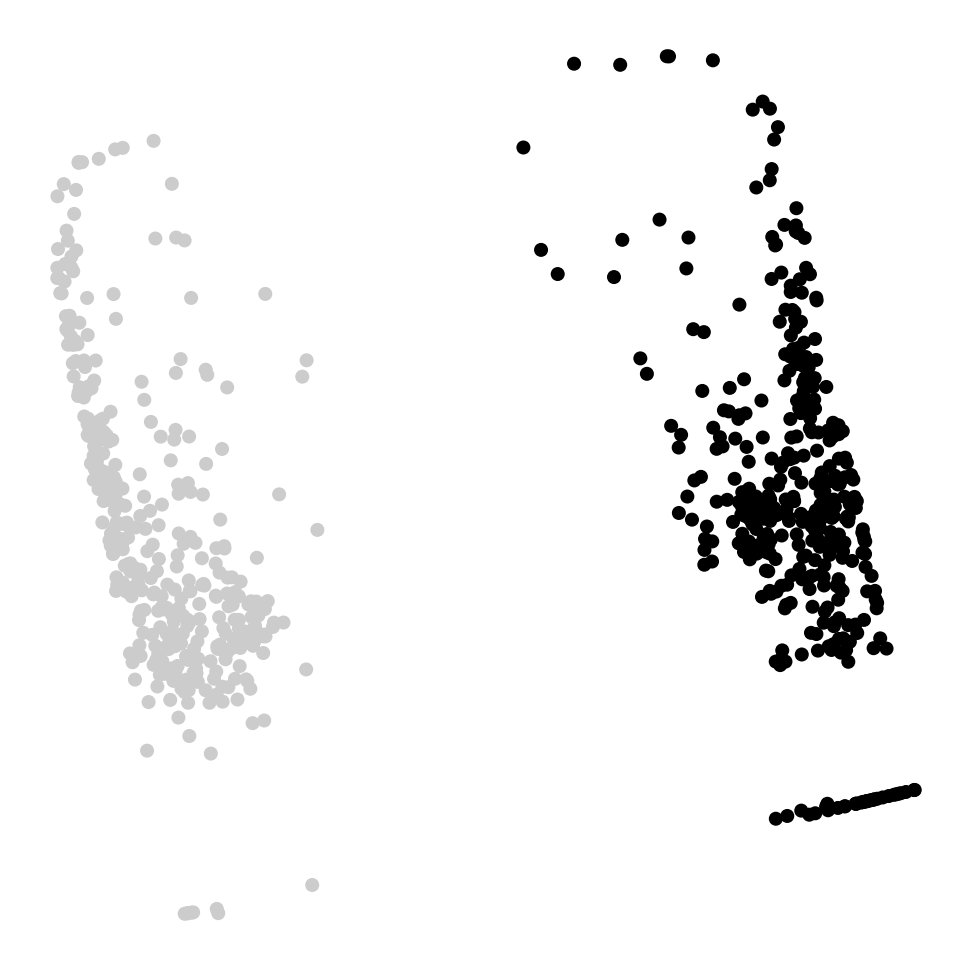

In [124]:
fig, ax = plt.subplots(figsize=(7,7))

x = adata.obsm["X_pca"][:,0]
y = adata.obsm["X_pca"][:,1]
c = adata.obs["plate"].astype("category").cat.codes.astype(int)

ax.scatter(x, y, c = c, cmap='nipy_spectral')

ax.set_axis_off()

plt.tight_layout()
plt.show()

# Write anndata

In [125]:
adata.write("temporary/adata.h5ad")

... storing 'plate' as categorical
... storing 'well' as categorical
... storing 'lysate' as categorical


# Barcode QC

We will use the RPP30 gene to check that the whitelist barcode has the top most counts compared to its hamming one distance variants. This is a great QC to ensure that there are no problems with the barcodes. Since the reference contains no shared sequences of 11, each "gene" corresponds to one equivalence class. We will use equivalence class 4 which corresponds to the RPP30 gene.

In [126]:
s = pd.read_csv("temporary/out/sort.txt", header=None, names=["bcs", "umi", "ecs", "cnt"], sep="\t")

s = s[s["ecs"] == 316]

In [127]:
m = pd.read_csv("temporary/out/dump.txt", header=None, names=["old", "new"], sep="\t")

m = m.sort_values("new")

m["plate"]      = m["new"].map(pmap["plate"])
m["plate"]      = m["new"].map(pmap["plate"])
m["well"]       = m["new"].map(pmap["well"])
m["lysate"]     = m["new"].map(pmap["lysate"])
m["gene"]       = m["new"].map(pmap["gene"])
m["Twist"]      = m["new"].map(pmap["Twist"])
m["ATCC_RNA"]   = m["new"].map(pmap["ATCC_RNA"])
m["ATCC_viral"] = m["new"].map(pmap["ATCC_viral"])

m["old_cnt"] = m["old"].map(s.groupby("bcs")["cnt"].sum())
m["new_cnt"] = m["new"].map(s.groupby("bcs")["cnt"].sum())

In [128]:
m = m.dropna(subset=["old_cnt"])

In [129]:
bad = m[m["old_cnt"] > m["new_cnt"]]

### We find that many barcodes have less counts than there hamming distance variants

In [130]:
bad.new.unique().shape

(197,)

In [131]:
bad[["old", "new","plate", "well", "lysate", "old_cnt", "new_cnt"]]

old               new   plate well lysate  old_cnt  new_cnt
20976  CACGACATGATCTTGC  AACGACATAATCTTGC  Plate2  D12     NP      3.0      1.0
20967  CACGACATAATCTTGC  AACGACATAATCTTGC  Plate2  D12     NP     93.0      1.0
4622   ACCGACATAATCTTGC  AACGACATAATCTTGC  Plate2  D12     NP      3.0      1.0
4629   ACCGACATCAGATCTT  AACGACATCAGATCTT  Plate1  C11     NP      4.0      2.0
20970  CACGACATCAGATCTT  AACGACATCAGATCTT  Plate1  C11     NP     85.0      2.0
...                 ...               ...     ...  ...    ...      ...      ...
77105  TTGGCCAACATCTGAG  TTGGCCCACATCTGAG  Plate2  A06     NP      5.0      2.0
77351  TTGGCCTATCATGACA  TTGGCCCATCATGACA  Plate1  A06     NP      2.0      1.0
72727  TGGGCCCATCATGACA  TTGGCCCATCATGACA  Plate1  A06     NP     90.0      1.0
77112  TTGGCCAATCATGACA  TTGGCCCATCATGACA  Plate1  A06     NP      3.0      1.0
75347  TTAGCCCATCATGACA  TTGGCCCATCATGACA  Plate1  A06     NP      8.0      1.0

[400 rows x 7 columns]

## An example of an abberant barcode

In [132]:
bad[bad["new"] == "AGCCAAGAGAGGGCAT"][["old", "new","plate", "well", "lysate", "old_cnt", "new_cnt"]]

old               new   plate well lysate  old_cnt  new_cnt
29417  CGCCAAGAGCGGGCAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP      8.0      3.0
29395  CGCCAAGAGAGAGCAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP      4.0      3.0
29409  CGCCAAGAGAGGGGAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP      4.0      3.0
29368  CGCCAAGACAGGGCAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP     10.0      3.0
29407  CGCCAAGAGAGGGCGT  AGCCAAGAGAGGGCAT  Plate2  E11     NP      5.0      3.0
29313  CGCCAAGAAAGGGCAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP   2689.0      3.0
29405  CGCCAAGAGAGGGCAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP   9563.0      3.0
29404  CGCCAAGAGAGGGCAG  AGCCAAGAGAGGGCAT  Plate2  E11     NP     13.0      3.0
29402  CGCCAAGAGAGGGCAA  AGCCAAGAGAGGGCAT  Plate2  E11     NP      5.0      3.0
29408  CGCCAAGAGAGGGCTT  AGCCAAGAGAGGGCAT  Plate2  E11     NP     27.0      3.0
12476  AGTCAAGAAAGGGCAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP      7.0      3.0
29418  CGCCAAGAGGGGGCAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP      6.0      3.0
29423  CGCCAAGATAGGGCAT  AGCCAAGAGAGGGCAT  Plate2  E11     NP     94.0      3.0